In [1]:
import numpy as np
import sys
from scipy.integrate import odeint
from scipy.integrate import ode

%matplotlib notebook


sys.path.append('../scripts')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from elements import *
import measurement as me

In [4]:
import matplotlib.pyplot as plt
%matplotlib notebook

## Time Domain Simulation of a basic optomechanical system


In [130]:
omega_c = 5e9*np.pi*2
kappa_ex = 0.4e6*np.pi*2
kappa_0 = 0.3e6*np.pi*2
kappa = kappa_ex + kappa_0

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2

P_in = 7e-14

g_0 = 200*np.pi*2

Delta = -1*omega_m 
omega_drive = omega_c - Delta

from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']
omega_c = omdir['omega_c']

C = 4 * g**2/kappa/gamma_m

print ('Cooperativity C: ',C)

Cooperativity C:  0.1222579188668113


In [71]:
s_x = 1
s_y = 1

M = np.array([[-kappa/2, Delta   , 0         , 0         ]
             ,[-Delta  , -kappa/2, -2*g      , 0         ]
             ,[0       , 0       , -gamma_m/2, omega_m   ]
             ,[-2*g    , 0       , -omega_m  , -gamma_m/2]])

L_ex = np.array([[np.sqrt(kappa_ex), 0]
                ,[0                , np.sqrt(kappa_ex)]
                ,[0                , 0]
                ,[0                , 0]])

W = 3 * omega_m
N_s = 21
#fs = 10 * W/2/np.pi
fs = 0.1e9
dW = W / N_s
omega_ps = np.linspace(-W/2,W/2, N_s)    
S = np.zeros_like(omega_ps)*(1. + 0.0*1j)


for i, omega_p in enumerate(omega_ps):
    def model(a, t):
        a_in = np.array([s_x * np.cos(omega_p*t), s_y * np.sin(omega_p*t)]).T
        dadt = M @ a + L_ex @ a_in
        return dadt
    t1 = 5 * 2*np.pi*10/kappa
    t2 = 30 * np.min([2*np.pi*10/(np.abs(omega_p)+1e-1), 2*np.pi*10/(0.001*kappa)])
    T = t1 + t2
    N = max(int(fs * T), 1)
    t = np.linspace(0, T, N)
    a_0 = np.array([0, 0, 0, 0])
    a = odeint(model, a_0, t)
    N_f =  max(int(fs * t2), 1)
    freqs = np.fft.fftfreq(N_f) * fs
    A = 2 * np.fft.fft( (a[-N_f:,0] + 1j * a[-N_f:,1])/np.sqrt(2) ) / N_f
    l = np.abs(A) == max(np.abs(A))
    S[i] = A[l] / np.sqrt(s_x**2 + s_y**2)

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
a = Mode('a', omega_c)
a_inex = Input('ex', a, kappa_ex, kind = 'drive', omega_drive = omega_drive, bath_temp=30000e-1)
a_in0 = Input('0', a, kappa_0, kind = 'bath', bath_temp=1000e0)

b = Mode('b', omega_m)

b_in0 = Input('0', b, gamma_m, kind = 'bath', bath_temp=10e-3)

g_ab = Coupling(a, b, g * np.array([1,0,0,0]))

sys_om = System([a, b], [a_in0,b_in0 , a_inex], [g_ab])


a_outex = Output(sys_om, a_inex)


omegas_newex, S_out_IOpy = me.linear_response(omega_drive+omega_ps, sys_om, a_outex, a_inex, plot = 0)

In [ ]:

plt.figure()
plt.plot(omega_ps/2/np.pi, np.abs(S[::-1]), label = 'Simulation')
plt.plot(omega_ps/2/np.pi, np.abs( (1-S_out_IOpy)/np.sqrt(kappa_ex) ), linestyle = '--', label = 'IOpy')
plt.xlabel('Frequency [Hz]')
plt.ylabel('|S|')
plt.legend()

plt.figure()
plt.plot(omega_ps[::1]/2/np.pi, -np.angle(S[::-1]), 'o',label = 'Simulation')
plt.plot(omega_ps/2/np.pi, np.angle( (1-S_out_IOpy)/np.sqrt(kappa_ex) ), linestyle = '--', label = 'IOpy')
plt.xlabel('Frequency [Hz]')
plt.ylabel('<S')
plt.legend()

<IPython.core.display.Javascript object>


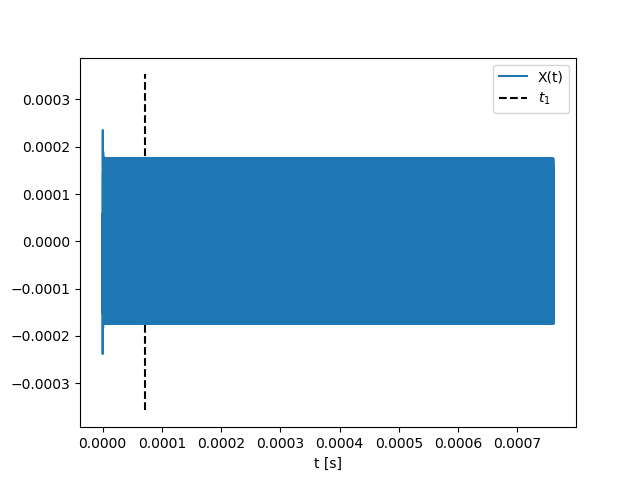

<IPython.core.display.Javascript object>


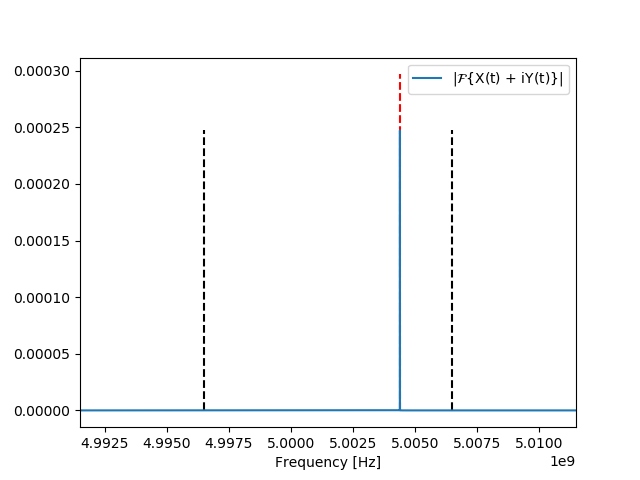

0.0002472679117500868


<IPython.core.display.Javascript object>


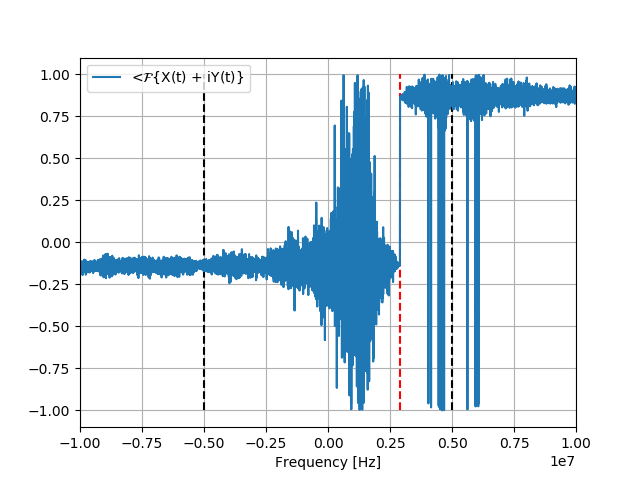

In [131]:
s_x = 1
s_y = 1

Delta = 0.3*omega_m 
omega_drive = omega_c + Delta

M = np.array([[-kappa/2, -Delta   , 0       , 0       ]
             ,[Delta  , -kappa/2, -2*g    , 0       ]
             ,[0       , 0       , -gamma_m/2       , omega_m ]
             ,[-2*g    , 0       , -omega_m, -gamma_m/2]])

L_ex = np.array([[np.sqrt(kappa_ex), 0]
                ,[0                , np.sqrt(kappa_ex)]
                ,[0                , 0]
                ,[0                , 0]])

omega_p = omega_m-3.0*kappa

def model(a, t):
        a_in = np.array([s_x * np.cos(omega_p*t), s_y * np.sin(omega_p*t)]).T
        dadt = M @ a + L_ex @ a_in
        return dadt
    
a_0 = np.array([0, 0, 0, 0])

#N=5000
fs = 1e9#100 * (np.abs(omega_p)/2/np.pi)
t1 = 5 * 2*np.pi*10/kappa
t2 = 200 * np.min([2*np.pi*10/(np.abs(omega_p)+1e-1), 2*np.pi*10/(0.001*kappa)])
T = t1 + t2
N = int(fs * T)
t = np.linspace(0, T, N)
a_in = np.array([np.cos(omega_p*t), np.sin(omega_p*t)])
a = odeint(model, a_0, t)

plt.figure()
plt.plot(t, a[:,0], label = 'X(t)')
plt.vlines(x=t1, ymin=min(a[:,0])*1.5, ymax=max(a[:,0])*1.5,linestyles='--',label='$t_1$')
plt.xlabel('t [s]')
plt.legend()

### Fourier Analysis

N_f = int(fs * t2)
freqs = np.fft.fftfreq(N_f) * fs
A = 2 * np.fft.fft(a[-N_f:,0] + 1j * a[-N_f:,1]) / N_f/np.sqrt(2)



plt.figure()
plt.plot(omega_drive/2/np.pi+np.fft.fftshift(freqs), np.abs(np.fft.fftshift(A)), label = '|$\mathcal{F}${X(t) + iY(t)}|')
plt.vlines([omega_drive/2/np.pi+1*omega_m/2/np.pi,omega_drive/2/np.pi-1*omega_m/2/np.pi], 0,max(np.abs(A)), linestyles='--', colors='black')
plt.vlines(omega_drive/2/np.pi+omega_p/2/np.pi, 0,max(np.abs(A))*1.2, linestyles='--', colors='red')
plt.xlim(omega_drive/2/np.pi-2*omega_m/2/np.pi,omega_drive/2/np.pi+2*omega_m/2/np.pi)
plt.xlabel('Frequency [Hz]')
plt.legend()

from scipy.signal import find_peaks
print(max(np.abs(A)))
#i = np.abs(A) == max(np.abs(A))
#i = np.abs(freqs - omega_m/2/np.pi) == min(np.abs(freqs - omega_m/2/np.pi))
i,_ = find_peaks(np.abs(A),height=10*min(np.abs(A)))
#plt.plot(freqs[i], np.abs(A[i]), 'o')
#print(np.abs(A[i]))
#print(i)
plt.figure()
plt.plot(np.fft.fftshift(freqs), np.angle(np.fft.fftshift(A))/np.pi, label = '<$\mathcal{F}${X(t) + iY(t)}')
plt.xlim((-2*omega_m/2/np.pi,2*omega_m/2/np.pi))
plt.vlines([1*omega_m/2/np.pi,-1*omega_m/2/np.pi], -1, 1, linestyles='--', colors='black')
plt.vlines(omega_p/2/np.pi, -1, 1, linestyles='--', colors='red')
plt.xlabel('Frequency [Hz]')
plt.legend()
plt.grid()


In [2]:
import numpy as np
import sys
from scipy.integrate import odeint
from scipy.integrate import ode

%matplotlib notebook


sys.path.append('../scripts')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from elements import *
import measurement as me

In [5]:
import matplotlib.pyplot as plt
%matplotlib notebook

## Time Domain Simulation of a Simple Optomechanical System


In [219]:
omega_c = 5e9*np.pi*2

kappa_0 = 0.3e6*np.pi*2
kappa_ex = 0.4e6*np.pi*2
kappa = kappa_0 + kappa_ex

omega_m = 5e6*np.pi*2
gamma_m = 100*np.pi*2

P_in = 5e-9

g_0 = 200*np.pi*2

Delta = 1*omega_m 
omega_drive = omega_c - Delta

from DCnonlinearities import optomechanics

omdir = optomechanics(P_in, kappa_0, kappa_ex, omega_c, omega_drive, omega_m, g_0)

g= omdir['g']
omega_c = omdir['omega_c']

C = 4 * g**2/kappa/gamma_m

print ('Cooperativity C: ',C)

Cooperativity C:  8973.133852515715


In [224]:
#a = (X, Y, Q, P)

s_x = 1
s_y = 1

M = np.array([[-kappa/2, Delta   , 0       , 0       ]
             ,[-Delta  , -kappa/2, -2*g    , 0       ]
             ,[0       , 0       , 0       , omega_m ]
             ,[-2*g    , 0       , -omega_m, -gamma_m]])

L_ex = np.array([[np.sqrt(kappa_ex), 0]
                ,[0                , np.sqrt(kappa_ex)]
                ,[0                , 0]
                ,[0                , 0]])

omega_ps = np.linspace(-1.5*omega_m, 1.5*omega_m, 100)

X = np.zeros_like(omega_ps)
Y = np.zeros_like(omega_ps)
Q = np.zeros_like(omega_ps)
P = np.zeros_like(omega_ps)


for i, omega_p in enumerate(omega_ps):
    def model(a, t):
        a_in = np.array([s_x * np.cos(omega_p*t), s_y * np.sin(omega_p*t)])
        dadt = M @ a + L_ex @ a_in
        return dadt
    a_0 = np.array([X[i-1], Y[i-1], Q[i-1], P[i-1]])
    t = np.linspace(0, 20/kappa_0, 1000)
    a_in = np.array([np.cos(omega_p*t), np.sin(omega_p*t)])
    a = odeint(model, a_0, t)
    X[i] = 2 * np.sqrt(np.mean(a[:,0]**2))
    Y[i] = 2 * np.sqrt(np.mean(a[:,1]**2))
    Q[i] = 2 * np.sqrt(np.mean(a[:,2]**2))
    P[i] = 2 * np.sqrt(np.mean(a[:,3]**2))

<IPython.core.display.Javascript object>


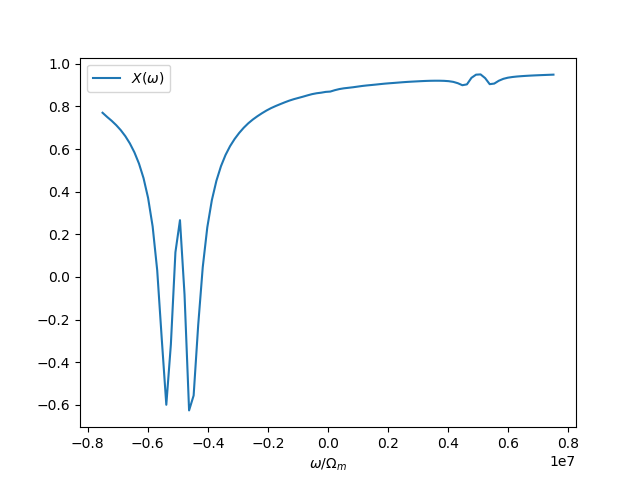

<IPython.core.display.Javascript object>


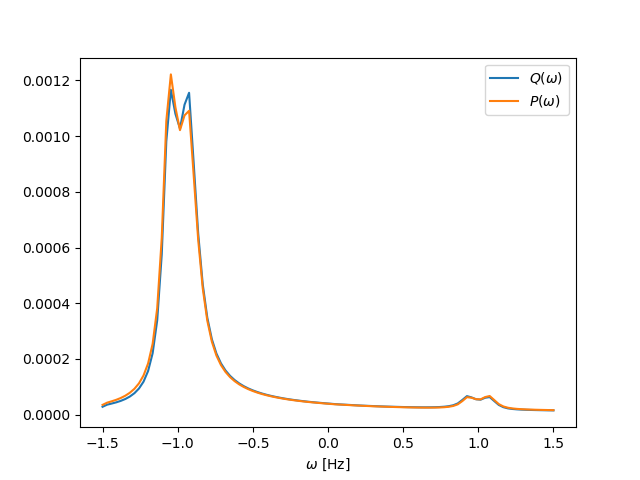

In [225]:
plt.figure()
plt.plot(omega_ps/2/np.pi, 1 - np.sqrt(kappa_ex) * X, label = '$X(\omega)$')
plt.xlabel('$\omega/\Omega_m$')
plt.legend()

plt.figure()
plt.plot(omega_ps/omega_m, Q, label = '$Q(\omega)$')
plt.plot(omega_ps/omega_m, P, label = '$P(\omega)$')
plt.xlabel('$\omega$ [Hz]')
plt.legend()

In [3]:
L_ex = np.array([[1, 0]
                ,[0                , 1]
                ,[0                , 0]
                ,[0                , 0]])

In [4]:
L_ex

array([[1, 0],
       [0, 1],
       [0, 0],
       [0, 0]])

In [5]:
In = np.array([[1, 1]
                ,[0                , 0]
                ,[0                , 0]
                ,[0                , 0]]).T

In [10]:
In = np.array([2,-2]).T

In [11]:
L_ex @ In

array([ 2, -2,  0,  0])

In [28]:
np.abs(1 + 1j)

1.4142135623730951

In [132]:
a = np.array([1, 1, 3, 4])
v = a == min(a)

In [133]:
v

array([ True,  True, False, False])

In [147]:
a = np.array([1+2*1j, 2 + 1*1j, np.sqrt(5)/2 + 1j*np.sqrt(5)/2])

In [148]:
max(a)

(2+1j)